In [34]:
import csv
import argparse
import os
import io

from bvh_converter.bvhplayer_skeleton import *

%load_ext autoreload
%autoreload 2

In [4]:
filename = r'C:\Users\miracleyoo\Downloads\miku_bluestar.bvh'

In [41]:
print("Reading BVH file...",)
my_bvh = ReadBVH(filename)  # Doesn't actually read the file, just creates
# a readbvh object and sets up the file for
# reading in the next line.
my_bvh.read()  # Reads and parses the file.

hips = process_bvhnode(my_bvh.root.children[1])  # Create joint hierarchy
print("done")

Reading BVH file...
done


In [199]:
hips = process_bvhnode(my_bvh.root)
[i.name for i in hips.children[1].children[0].children]

['グルーブ']

In [18]:
import numpy as np
np.array(my_bvh.keyframes).shape

(6836, 1491)

In [111]:
t = my_bvh.root.children[0]

In [132]:
hips = process_bvhnode(my_bvh.root.children[0])

In [133]:
print("Building skeleton...",)
myskeleton = Skeleton(hips, keyframes=my_bvh.keyframes, frames=my_bvh.frames, dt=my_bvh.dt)
print("done")

Building skeleton...
['Xposition', 'Yposition', 'Zposition', 'Xrotation', 'Yrotation', 'Zrotation']
done


In [138]:
len(myskeleton.keyframes[0])

1491

In [44]:
import pandas as pd

In [66]:
parts_name = ['頭', '腕.R', '腕.L', 'ひじ.R', 'ひじ.L', '足.R', '足.L', '手首.R', '手首.L',  'ひざ.R', 'ひざ.L', '足首.R', '足首.L']
col_names = []
_ = [col_names.extend((k+'.X', k+'.Y', k+'.Z')) for k in parts_name]
print(len(col_names), col_names)

39 ['頭.X', '頭.Y', '頭.Z', '腕.L.X', '腕.L.Y', '腕.L.Z', '腕.R.X', '腕.R.Y', '腕.R.Z', 'ひじ.L.X', 'ひじ.L.Y', 'ひじ.L.Z', 'ひじ.R.X', 'ひじ.R.Y', 'ひじ.R.Z', '手首.L.X', '手首.L.Y', '手首.L.Z', '手首.R.X', '手首.R.Y', '手首.R.Z', '足.L.X', '足.L.Y', '足.L.Z', '足.R.X', '足.R.Y', '足.R.Z', 'ひざ.L.X', 'ひざ.L.Y', 'ひざ.L.Z', 'ひざ.R.X', 'ひざ.R.Y', 'ひざ.R.Z', '足首.L.X', '足首.L.Y', '足首.L.Z', '足首.R.X', '足首.R.Y', '足首.R.Z']


In [58]:
csv_file = r'C:\Users\miracleyoo\Downloads\miku_bluestar_worldpos.csv'
raw = pd.read_csv(csv_file, encoding='gbk')

In [78]:
selected_joints = raw[col_names]
joints_dict = {}
for part in parts_name:
    joint = selected_joints[[part+'.X', part+'.Y', part+'.Z']]
    joints_dict[part] = joint.to_numpy()

In [113]:
print(list(raw.columns))

In [124]:
import pickle as pkl
import os.path as op

def filter_columns(file_in, file_out=None, ret=False):
    parts_name = ['頭', '腕.R', '腕.L', 'ひじ.R', 'ひじ.L', '足.R', '足.L', '手首.R', '手首.L',  'ひざ.R', 'ひざ.L', '足首.R', '足首.L']
    col_names = []
    _ = [col_names.extend((k+'.X', k+'.Y', k+'.Z')) for k in parts_name]
    raw = pd.read_csv(file_in, encoding='gbk')
    selected_joints = raw[col_names]
    joints_dict = {}
    joint_list = []
    for part in parts_name:
        joint = selected_joints[[part+'.X', part+'.Y', part+'.Z']]
        joints_dict[part] = joint.to_numpy()
        joint_list.append(joints_dict[part])
    if file_out is None:
        file_out = op.splitext(file_in)[0]+'_kp13.pkl'
    with open(file_out, 'wb') as f:
        pkl.dump(joints_dict, f)
    if ret:
        return np.array(joint_list)

In [126]:
joint_arr = filter_columns(csv_file, ret=True)
print(joint_arr.shape)

(13, 6836, 3)


In [107]:
x_mu = raw['センター.X'].to_numpy()
y_mu = raw['センター.Y'].to_numpy()
z_mu = raw['センター.Z'].to_numpy()

In [108]:
sum(y_mu!=0)

0

In [142]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_skeleton_lines(x, y, z):
    """
    From DHP19 toolbox
    """
    # rename joints to identify name and axis
    x_head, x_shoulderR, x_shoulderL, x_elbowR = x[0], x[1], x[2], x[3]
    x_elbowL, x_hipR, x_hipL = (
        x[4],
        x[5],
        x[6],
    )
    x_handR, x_handL, x_kneeR = (
        x[7],
        x[8],
        x[9],
    )
    x_kneeL, x_footR, x_footL = x[10], x[11], x[12]

    y_head, y_shoulderR, y_shoulderL, y_elbowR = y[0], y[1], y[2], y[3]
    y_elbowL, y_hipR, y_hipL = (
        y[4],
        y[5],
        y[6],
    )
    y_handR, y_handL, y_kneeR = (
        y[7],
        y[8],
        y[9],
    )
    y_kneeL, y_footR, y_footL = y[10], y[11], y[12]

    z_head, z_shoulderR, z_shoulderL, z_elbowR = z[0], z[1], z[2], z[3]
    z_elbowL, z_hipR, z_hipL = (
        z[4],
        z[5],
        z[6],
    )
    z_handR, z_handL, z_kneeR = (
        z[7],
        z[8],
        z[9],
    )
    z_kneeL, z_footR, z_footL = z[10], z[11], z[12]

    # definition of the lines of the skeleton graph
    skeleton = np.zeros((14, 3, 2))
    skeleton[0, :, :] = [
        [x_head, x_shoulderR],
        [y_head, y_shoulderR],
        [z_head, z_shoulderR],
    ]
    skeleton[1, :, :] = [
        [x_head, x_shoulderL],
        [y_head, y_shoulderL],
        [z_head, z_shoulderL],
    ]
    skeleton[2, :, :] = [
        [x_elbowR, x_shoulderR],
        [y_elbowR, y_shoulderR],
        [z_elbowR, z_shoulderR],
    ]
    skeleton[3, :, :] = [
        [x_elbowL, x_shoulderL],
        [y_elbowL, y_shoulderL],
        [z_elbowL, z_shoulderL],
    ]
    skeleton[4, :, :] = [
        [x_elbowR, x_handR],
        [y_elbowR, y_handR],
        [z_elbowR, z_handR],
    ]
    skeleton[5, :, :] = [
        [x_elbowL, x_handL],
        [y_elbowL, y_handL],
        [z_elbowL, z_handL],
    ]
    skeleton[6, :, :] = [
        [x_hipR, x_shoulderR],
        [y_hipR, y_shoulderR],
        [z_hipR, z_shoulderR],
    ]
    skeleton[7, :, :] = [
        [x_hipL, x_shoulderL],
        [y_hipL, y_shoulderL],
        [z_hipL, z_shoulderL],
    ]
    skeleton[8, :, :] = [[x_hipR, x_kneeR], [y_hipR, y_kneeR], [z_hipR, z_kneeR]]
    skeleton[9, :, :] = [[x_hipL, x_kneeL], [y_hipL, y_kneeL], [z_hipL, z_kneeL]]
    skeleton[10, :, :] = [
        [x_footR, x_kneeR],
        [y_footR, y_kneeR],
        [z_footR, z_kneeR],
    ]
    skeleton[11, :, :] = [
        [x_footL, x_kneeL],
        [y_footL, y_kneeL],
        [z_footL, z_kneeL],
    ]
    skeleton[12, :, :] = [
        [x_shoulderR, x_shoulderL],
        [y_shoulderR, y_shoulderL],
        [z_shoulderR, z_shoulderL],
    ]
    skeleton[13, :, :] = [[x_hipR, x_hipL], [y_hipR, y_hipL], [z_hipR, z_hipL]]
    return skeleton

def get_3d_ax():
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    # Bonus: To get rid of the grid as well:
    ax.grid(False)
    ax.view_init(30, 240)
    return ax

def plot_3d(points, ax, c="red", limits=None, plot_lines=True):
    """
    Plot the provided skeletons in 3D coordinate space
    Args:
        ax: axis for plot
        y_true_pred: joints to plot in 3D coordinate space
        c: color (Default value = 'red')
        limits: list of 3 ranges (x, y, and z limits)
        plot_lines:  (Default value = True)

    Note:
        Plot the provided skeletons. Visualization purpose only

    From DHP19 toolbox
    """

    if limits is None:
        limits = [[-5, 5], [-5, 5], [0, 15]]

    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    ax.scatter(x, y, z, zdir="z", s=20, c=c, marker="o", depthshade=True)

    lines_skeleton = get_skeleton_lines(x, y, z)

    if plot_lines:
        for line in range(len(lines_skeleton)):
            ax.plot(
                lines_skeleton[line, 0, :],
                lines_skeleton[line, 1, :],
                lines_skeleton[line, 2, :],
                c,
                label="gt",
            )

    ax.set_xlabel("X Label")
    ax.set_ylabel("Y Label")
    ax.set_zlabel("Z Label")
    x_limits = limits[0]
    y_limits = limits[1]
    z_limits = limits[2]
    x_range = np.abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = np.abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = np.abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)
    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5 * np.max([x_range, y_range, z_range])
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def plot_skeleton_3d(points):
    """
        Args:
           M: extrinsic matrix as tensor of shape 4x3
           xyz: torch tensor of shape NUM_JOINTSx3
           pred: torch tensor of shape NUM_JOINTSx3
        """

    ax = get_3d_ax()
    plot_3d(points, ax, c='red')

C:\Users\miracleyoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


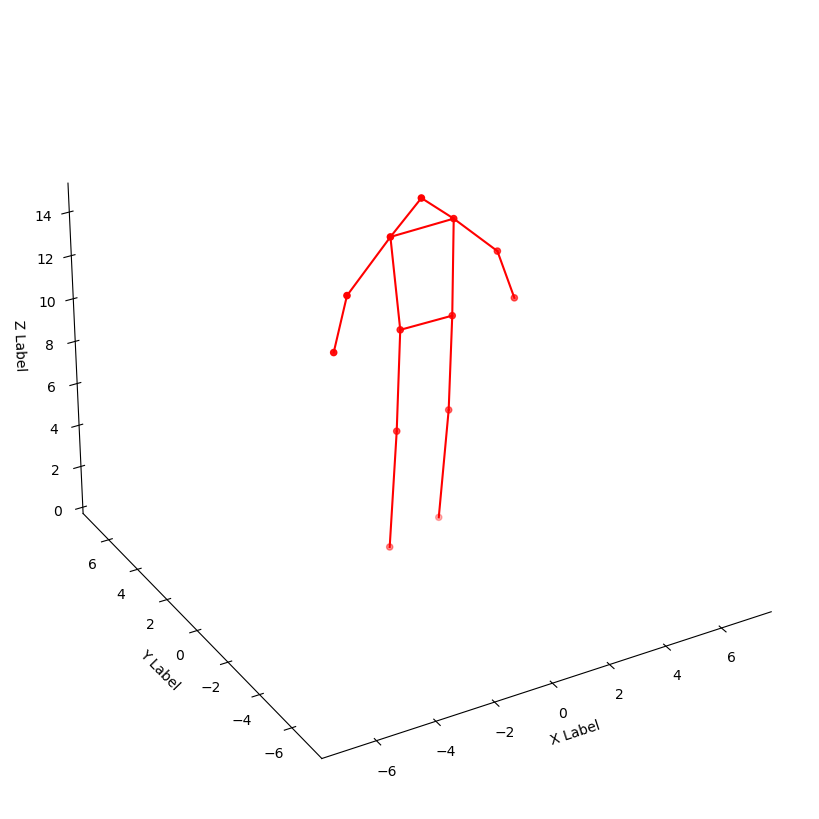

In [182]:
plot_skeleton_3d(joint_arr[:,6,:])
plt.show()